<a href="https://colab.research.google.com/githubfabiobento/dnn-course-2024-1/blob/main/00_course_folder/adv_cv/class_2/22%20-%20Atividade%20Avaliativa/C3W2_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

adaptado de [Visão computacional avançada com TensorFlow](https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow?specialization=tensorflow-advanced-techniques) de [Laurence Moroney](https://laurencemoroney.com/) e [Andrew Ng](https://www.coursera.org/instructor/andrewng) , [DeepLearning.AI](https://www.deeplearning.ai/)

# Detecção de Zumbis

Nessa tarefa avaliativa você usará a API de detecção de objetos e treinará novamente o [RetinaNet](https://arxiv.org/abs/1708.02002) para detectar zumbis usando apenas 5 imagens de treinamento. Você configurará o modelo para restaurar os pesos pré-treinados e ajustará as camadas de classificação.


<img src='https://drive.google.com/uc?export=view&id=18Ck0qNSZy9F1KsUKWc4Jv7_x_1e_fXTN' alt='zombie'>

## Exercícios

* [ Exercício 1 - Importar pacotes da API de detecção de objetos](#exercise-1)
* [Exercício 2 - Visualize as imagens de treinamento](#exercise-2)
* [Exercício 3 - Definir o dicionário de índice de categoria](#exercise-3)
* [Exercício 4 - Baixar pontos de verificação](#exercise-4)
* [Exercício 5.1 - Localizar e ler o arquivo de configuração](#exercise-5-1)
* [Exercício 5.2 - Modificar a configuração do modelo](#exercise-5-2)
* [Exercício 5.3 - Modificar model_config](#exercise-5-3)
* [ Exercício 5.4 - Construir o modelo personalizado](#exercise-5-4)
* [Exercício 6.1 - Definir pontos de controle para o preditor de caixa](#exercise-6-1)
* [Exercício 6.2 - Definir o ponto de verificação do modelo temporário](#exercise-6-2)
* [Exercício 6.3 - Restaurar o ponto de verificação](#exercise-6-2)
* [Exercício 7 - Execute uma imagem fictícia para gerar as variáveis do modelo](#exercise-7)
* [Exercício 8 - Definir hiperparâmetros de treinamento](#exercise-8)
* [Exercício 9 - Selecione as variáveis da camada de previsão](#exercise-9)
* [Exercício 10 - Definir a etapa de treinamento](#exercise-10)
* [Exercício 11 - Pré-processar, prever e pós-processar uma imagem](#exercise-11)

## Instalação

Você começará instalando o Tensorflow 2 [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).

In [ ]:
# descomente a próxima linha se quiser excluir um diretório de modelos existente
!rm -rf ./models/

# clonar o Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 3909, done.
remote: Counting objects: 100% (3909/3909), done.
remote: Compressing objects: 100% (3012/3012), done.
remote: Total 3909 (delta 1129), reused 2001 (delta 844), pack-reused 0
Receiving objects: 100% (3909/3909), 49.65 MiB | 11.08 MiB/s, done.
Resolving deltas: 100% (1129/1129), done.
Updating files: 100% (3538/3538), done.


In [ ]:
# Compilar os buffers de protocolo da API de detecção de objetos
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

Execute a célula abaixo para escrever um arquivo baseado no [setup script](https://github.com/tensorflow/models/blob/master/research/object_detection/packages/tf2/setup.py) do repositório oficial para trabalhar com os pacotes na versão atual do Colab.

Removi alguns dos pacotes que não são necessários nessa atividade para tornar a instalação mais rápida.

In [ ]:
%%writefile models/research/setup.py

import os
from setuptools import find_packages
from setuptools import setup

REQUIRED_PACKAGES = [
    'tf-models-official==2.8.0',
    'tensorflow_io==0.24.0',
    'numpy==1.21.5'
]

setup(
    name='object_detection',
    version='0.1',
    install_requires=REQUIRED_PACKAGES,
    include_package_data=True,
    packages=(
        [p for p in find_packages() if p.startswith('object_detection')] +
        find_packages(where=os.path.join('.', 'slim'))),
    package_dir={
        'datasets': os.path.join('slim', 'datasets'),
        'nets': os.path.join('slim', 'nets'),
        'preprocessing': os.path.join('slim', 'preprocessing'),
        'deployment': os.path.join('slim', 'deployment'),
        'scripts': os.path.join('slim', 'scripts'),
    },
    description='Tensorflow Object Detection Library',
    python_requires='>3.6',
)

Writing models/research/setup.py


In [ ]:
# Rode o script que você acabou de escrever
!python -m pip install models/research

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./models/research
  Preparing metadata (setup.py) ... done
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696894 sha256=dc31d7dd5f065868b0e03900be9f3ec29a78b35abb9683f96c715a86ec5d7c22
  Stored in directory: /tmp/pip-ephem-wheel-cache-kbfwbk03/wheels/53/dd/70/2de274d6c443c69d367bd6a5606f95e5a6df61aacf1435ec0d
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


## Importações

Vamos agora importar os pacotes que você usará nesta tarefa.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version só existe no Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


<a name='exercise-1'></a>
### **Exercício 1**: Importar pacotes da API de detecção de objetos

Importe os módulos necessários do pacote `object_detection`.
- Do pacote [utils](https://github.com/tensorflow/models/tree/master/research/object_detection/utils):
  - [label_map_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/label_map_util.py)
  - [config_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/config_util.py): Você usará para ler as configurações do modelo de um arquivo .config e, em seguida, modificar essa configuração
  - [visualization_utils](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py): dê a esse arquivo o alias `viz_utils`, pois ele será usado em alguns códigos de visualização que serão fornecidos a você posteriormente.
  - [colab_utils](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/colab_utils.py)
- Do pacote [builders](https://github.com/tensorflow/models/tree/master/research/object_detection/builders):
  - [model_builder](https://github.com/tensorflow/models/blob/master/research/object_detection/builders/model_builder.py): Constrói o modelo de acordo com a configuração do modelo que você especificar.

In [ ]:
### INICIE O CÓDIGO AQUI (Substitua as instâncias de `None` pelo seu código)
# Importar o módulo utilitário de mapa de rótulos
from object_detection.utils import label_map_util

# Importar o módulo para ler e atualizar os arquivos de configuração.
from object_detection.utils import config_util

# Módulo de importação para visualização. Use o alias `viz_utils`
from object_detection.utils import visualization_utils as viz_utils

# Módulo de importação para criar o modelo de detecção
from object_detection.builders import model_builder
### TERMINE O CÓDIGO AQUI ###

# Módulo de importação para utilitários no Colab
from object_detection.utils import colab_utils

## Utilitários

Você definirá algumas funções utilitárias para carregar imagens e plotar detecções. Esse código é fornecido para você.

In [ ]:
def load_image_into_numpy_array(path):
  """Carrega uma imagem de um arquivo em uma matriz numpy.

    Coloca a imagem em uma matriz numpy para alimentar o gráfico do tensorflow.
    Observe que, por convenção, coloquei em uma matriz numpy com a forma
    (altura, largura, canais), onde canais=3 para RGB.

    Args:
    path: um caminho de arquivo.

    Retorna:
    matriz numpy uint8 com formato (img_height, img_width, 3)
  """

  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size

  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Função de wrapper para visualizar as detecções.

    Args:
    image_np: matriz numérica uint8 com formato (img_height, img_width, 3)
    boxes: uma matriz numérica de forma [N, 4]
    classes: uma matriz numérica de formato [N]. Observe que os índices de classe são baseados em 1,
          e correspondem às chaves no mapa de rótulos.
    scores: uma matriz numpy de forma [N] ou None.  Se scores=None, então
          essa função pressupõe que as caixas a serem plotadas são caixas de verdade
          e plotará todas as caixas como pretas, sem classes ou pontuações.
    category_index: um dict contendo dicionários de categorias (cada um contendo
          índice de categoria `id` e nome de categoria `name`), codificados por índices de categoria.
    figsize: tamanho da figura.
    image_name: um nome para o arquivo de imagem.
  """
  image_np_with_annotations = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)

  if image_name:
      plt.imsave(image_name, image_np_with_annotations)

  else:
      plt.imshow(image_np_with_annotations)


## Faça o download dos dados de zumbis

Agora você obterá 5 imagens de zumbis que serão usadas para treinamento.
- Os zumbis estão hospedados em um bucket do Google.
- Você pode fazer download e descompactar as imagens em um diretório local `training/` executando a célula abaixo.

In [ ]:
# Descomente as próximas 2 linhas se quiser excluir um diretório zip e de treinamento existente
!rm training-zombie.zip
!rm -rf ./training

# Faça o download das imagens
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-3-public/datasets/training-zombie.zip \
    -O ./training-zombie.zip

# Descompacte em um diretório local
local_zip = './training-zombie.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()

--2023-06-13 14:04:39--  https://storage.googleapis.com/tensorflow-3-public/datasets/training-zombie.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1915446 (1.8M) [application/zip]
Saving to: ‘./training-zombie.zip’

./training-zombie.z 100%[===================>]   1.83M  --.-KB/s    in 0.01s   

2023-06-13 14:04:39 (179 MB/s) - ‘./training-zombie.zip’ saved [1915446/1915446]



<a name='exercise-2'></a>

### **Exercício 2**: Visualizar as imagens de treinamento

Em seguida, você deverá inspecionar as imagens que acabou de baixar.

* Substitua as instâncias de `None` abaixo para carregar e visualizar as 5 imagens de treinamento.
* Você pode inspecionar o diretório *training* (usando o botão `Files` no lado esquerdo deste Colab) para ver os nomes dos arquivos das imagens de zumbis. Os caminhos para as imagens terão a seguinte aparência:

```
./training/training-zombie1.jpg
./training/training-zombie2.jpg
./training/training-zombie3.jpg
./training/training-zombie4.jpg
./training/training-zombie5.jpg
```
- Para definir caminhos de arquivos, você usará [os.path.join](https://www.geeksforgeeks.org/python-os-path-join-method/).  Por exemplo, se você quisesse criar o caminho './pasta_pai/nome_do_arquivo1.txt', poderia escrever:

`os.path.join('parent_folder', 'file_name' + str(1) + '.txt')`

* Você deverá ver as 5 imagens de treinamento depois de executar essa célula. Caso contrário, inspecione seu código, especialmente o `image_path`.

./training/training-zombie1.jpg
./training/training-zombie2.jpg
./training/training-zombie3.jpg
./training/training-zombie4.jpg
./training/training-zombie5.jpg


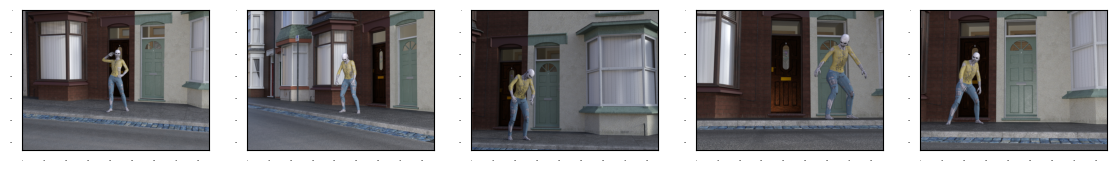

In [ ]:
%matplotlib inline

### INICIE O CÓDIGO AQUI (Substitua as instâncias de `None` pelo seu código)

# Atribua o nome (string) do diretório que contém as imagens de treinamento
train_image_dir = './training'

# declarar uma lista vazia
train_images_np = []

# Executar um loop for para cada imagem
for i in range(1, 6):
    # Definir o caminho (string) para cada imagem
    image_path = os.path.join(train_image_dir, 'training-zombie' + str(i) + '.jpg')
    print(image_path)
# carregar imagens em matrizes numpy e anexá-las a uma lista
    train_images_np.append(load_image_into_numpy_array(image_path))
### TERMINE O CÓDIGO AQUI ###

# Definir as configurações de plotagem via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plotar imagens
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 5, idx+1)
    plt.imshow(train_image_np)

plt.show()

<a name='gt_boxes_definition'></a>
## Preparar dados para treinamento (opcional)

Nesta seção, você criará suas caixas de ground-truth.

Você pode desenhar suas próprias caixas ou usar uma lista pré-preenchida de coordenadas que forneço abaixo.

In [ ]:
gt_boxes = []

#### Opção 1: desenhe suas próprias caixas de ground-truth
Se quiser desenhar suas próprias caixas, execute a próxima célula e o código de teste a seguir. Caso contrário, pule estas células opcionais.

* Desenhe uma caixa ao redor do zumbi em cada imagem.
* Clique no botão `next image` para ir para a próxima imagem
* Clique em "enviar" quando aparecer a mensagem "Todas as imagens foram concluídas!!!".

- Certifique-se de não deixar a caixa delimitadora muito grande.
  - Se a caixa for muito grande, o modelo poderá aprender as características do plano de fundo (por exemplo, porta, estrada, etc.) para determinar se há um zumbi ou não.
- Inclua o zumbi inteiro dentro da caixa.
- Como exemplo, vá até o início deste notebook para ver a caixa delimitadora em torno do zumbi.

In [ ]:
# Opção 1: desenhe suas próprias caixas de ground-truth

# Anotar as imagens de treinamento
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
gt_boxes

[array([[0.28442235, 0.42790152, 0.73275568, 0.57444314]]),
 array([[0.30108902, 0.46658851, 0.74608902, 0.6049238 ]]),
 array([[0.42108902, 0.1887456 , 0.93442235, 0.33880422]]),
 array([[0.16442235, 0.61664713, 0.78608902, 0.90973036]]),
 array([[0.30608902, 0.13950762, 0.82275568, 0.35052755]])]

In [ ]:
# Opção 1: desenhe suas próprias caixas de ground-truth
# CÓDIGO DE TESTE:
try:
  assert(len(gt_boxes) == 5), "Aviso: gt_boxes está vazio. Você clicou em `submit`?"

except AssertionError as e:
  print(e)

# verifica se há caixas para todas as 5 imagens
for gt_box in gt_boxes:
    try:
      assert(gt_box is not None),"Há menos de 5 conjuntos de coordenadas de caixa. " \
                                  "Execute novamente a célula acima para desenhar as caixas novamente.\n" \
                                  "Como alternativa, você pode executar a próxima célula para carregar caixas pré-determinadas " \
                                  "caixas de verdade terrestre."

    except AssertionError as e:
        print(e)
        break


ref_gt_boxes = [
        np.array([[0.27333333, 0.41500586, 0.74333333, 0.57678781]]),
        np.array([[0.29833333, 0.45955451, 0.75666667, 0.61078546]]),
        np.array([[0.40833333, 0.18288394, 0.945, 0.34818288]]),
        np.array([[0.16166667, 0.61899179, 0.8, 0.91910903]]),
        np.array([[0.28833333, 0.12543962, 0.835, 0.35052755]]),
      ]

for gt_box, ref_gt_box in zip(gt_boxes, ref_gt_boxes):
    try:
      assert(np.allclose(gt_box, ref_gt_box, atol=0.04)),"Uma das caixas é muito grande ou muito pequena. " \
                                                         "Por favor, redesenhe e deixe a caixa mais apertada ao redor do zumbi."

    except AssertionError as e:
      print(e)
      break

<a name='gt-boxes'></a>
#### Opção 2: usar as caixas ground_truth fornecidas
Você também pode usar essa lista se optar por não desenhar as caixas por conta própria.

In [ ]:
# Opção 2: usar as caixas de ground_truth fornecidas
# Defina isso como `True` se quiser substituir as caixas que você desenhou
override = False

# Caixas delimitadoras para cada um dos 5 zumbis encontrados em cada imagem.
# você pode usá-las em vez de desenhar as caixas você mesmo.
ref_gt_boxes = [
        np.array([[0.27333333, 0.41500586, 0.74333333, 0.57678781]]),
        np.array([[0.29833333, 0.45955451, 0.75666667, 0.61078546]]),
        np.array([[0.40833333, 0.18288394, 0.945, 0.34818288]]),
        np.array([[0.16166667, 0.61899179, 0.8, 0.91910903]]),
        np.array([[0.28833333, 0.12543962, 0.835, 0.35052755]]),
      ]

# se gt_boxes estiver vazio, use a referência
if not gt_boxes or override is True:
  gt_boxes = ref_gt_boxes

# Se gt_boxes não contiver 5 coordenadas de caixa, use a referência
for gt_box in gt_boxes:
    try:
      assert(gt_box is not None)

    except:
      gt_boxes = ref_gt_boxes

      break


#### Veja as coordenadas de sua caixa de ground-truth
Independentemente de você ter optado por desenhar suas próprias caixas ou usar as caixas fornecidas, verifique sua lista de coordenadas da caixa de ground-truth.

In [ ]:
# imprima as coordenadas de suas caixas de ground-truth
for gt_box in gt_boxes:
  print(gt_box)

[[0.28442235 0.42790152 0.73275568 0.57444314]]
[[0.30108902 0.46658851 0.74608902 0.6049238 ]]
[[0.42108902 0.1887456  0.93442235 0.33880422]]
[[0.16442235 0.61664713 0.78608902 0.90973036]]
[[0.30608902 0.13950762 0.82275568 0.35052755]]


Abaixo, adicionamos as anotações de classe. Para simplificar, assumimos apenas uma única classe, embora deva ser fácil estendê-la para lidar com várias classes. Também converteremos tudo para o formato que o loop de treinamento espera (por exemplo, conversão para tensores, representações de um ponto, etc.).

<a name='exercise-3'></a>

### **Exercício 3**: Definir o dicionário de índice de categoria

Você precisará informar ao modelo qual ID de classe inteira deve ser atribuído à categoria "zombie" e qual "nome" deve ser associado a esse ID.

- zombie_class_id: Por convenção, os números inteiros de ID de classe começam a ser numerados a partir de 1, 2, 3 e assim por diante.
  - Se houver uma classe de "background", ela poderá receber o número inteiro 0, mas, nesse caso, você está prevendo apenas uma classe de zumbis.
  - Como você está prevendo apenas uma classe (zumbi), atribua `1` ao ID da classe zumbi.

- category_index: Defina o dicionário `category_index`, que terá a mesma estrutura que esta:
```
{human_class_id :
  {'id'  : human_class_id,
   'name': 'human_so_far'}
}
```
- Defina `category_index` semelhante ao dicionário de exemplo acima, exceto para zumbis.
  - Isso será usado pelas funções seguintes para saber a classe `id` e o `nome` das imagens de zumbis.

- num_classes: Como você está prevendo uma classe, atribua `1` ao número de classes que o modelo preverá.
  - Isso será usado durante o pré-processamento de dados e novamente quando você configurar o modelo.


In [ ]:
### INICIE O CÓDIGO AQUI (Substitua as instâncias de `None` pelo seu código)

# Atribua o ID da classe zumbi
zombie_class_id = 1

# Definir um dicionário que descreve a classe zumbi
category_index = {zombie_class_id: {'id': zombie_class_id, 'name': 'zombie'}}

# Especifique o número de classes que o modelo irá prever
num_classes = 1
### TERMINE O CÓDIGO AQUI ###

In [ ]:
# CÓDIGO DE TESTE:

print(category_index[zombie_class_id])

{'id': 1, 'name': 'zombie'}


**Saída Esperada:**

```txt
{'id': 1, 'name': 'zombie'}
```

### Pré-processamento de dados
Agora você fará o pré-processamento dos dados para que eles sejam formatados corretamente antes de serem alimentados no modelo:
- Converter os rótulos de classe em representações de um único ponto
- converter tudo (ou seja, imagens de treinamento, caixas gt e rótulos de classe) em tensores.

Esse código é fornecido para você.

In [ ]:
# O `label_id_offset` desloca todas as classes por um determinado número de índices;
# fazemos isso para que o modelo receba rótulos one-hot em que as classes que não são
# do plano de fundo começam a contar no índice zero.

label_id_offset = 1
train_image_tensors = []

# Listas que contêm as classes codificadas com one-hot e as caixas de ground-truth
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    # converter a imagem de treinamento em tensor, adicionar dimensão de lote e adicionar à lista
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))
    # converter matriz numérica em tensor e, em seguida, adicionar à lista
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    # Aplique o deslocamento para ter classes de ground-truth com índice zero
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    # Fazer codificação one-hot para classes de ground-truth
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

print('Concluída a preparação dos dados.')

Concluída a preparação dos dados.


## Visualize os zumbis com suas caixas delimitadoras de ground-truth

Você deverá ver as 5 imagens de treinamento com as caixas delimitadoras depois de executar a célula abaixo. Caso contrário, execute novamente a [ferramenta de anotação] (#gt_boxes_definition) ou use a matriz `gt_boxes` pré-preenchida fornecida.

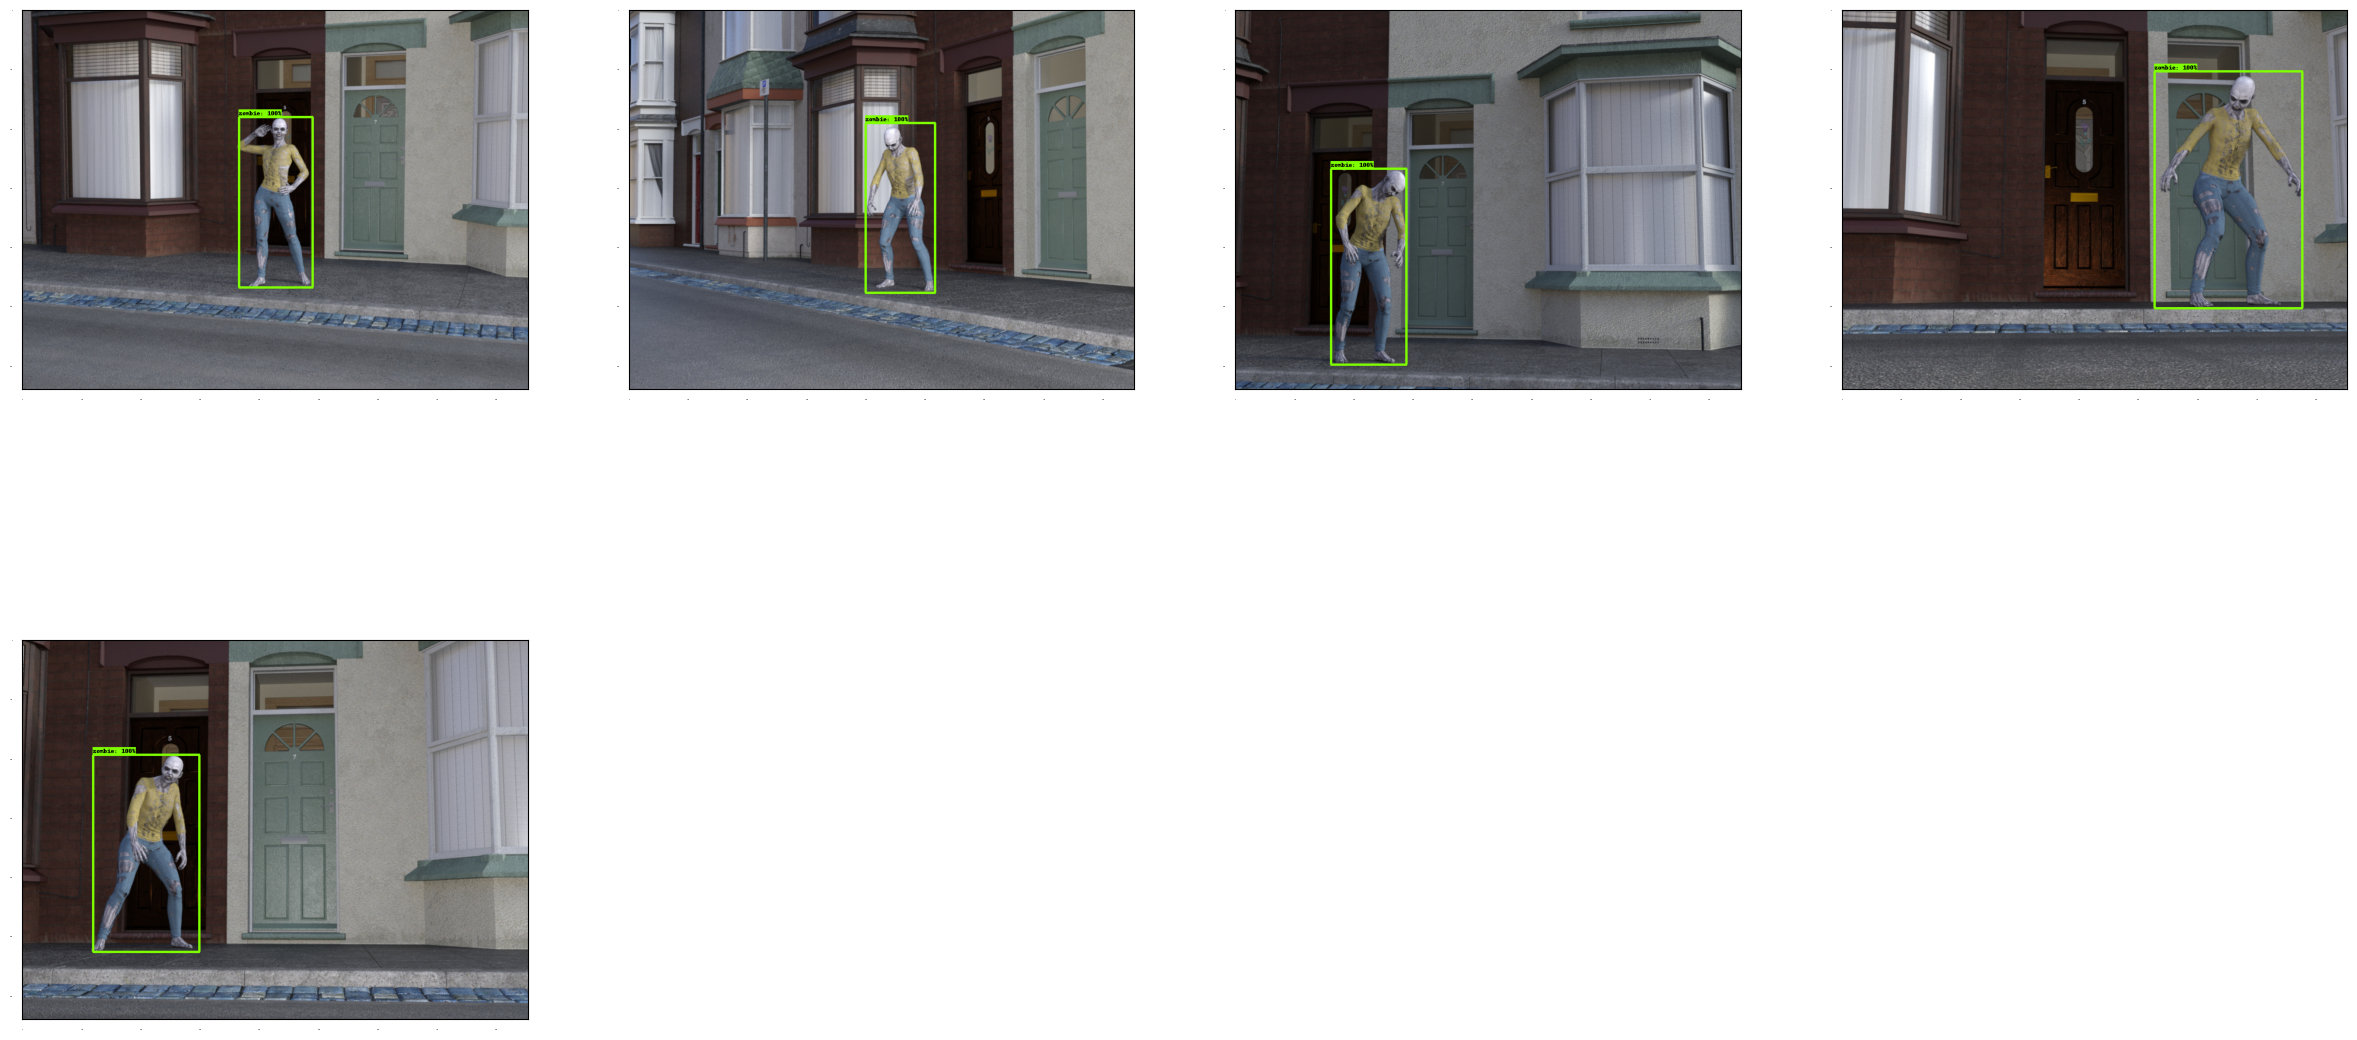

In [ ]:
# Dar às caixas uma pontuação de 100%
dummy_scores = np.array([1.0], dtype=np.float32)

# definir o tamanho da figura
plt.figure(figsize=(30, 15))

# use a função utilitária `plot_detections()` para desenhar as caixas de ground-truth
for idx in range(5):
  plt.subplot(2, 4, idx+1)
  plot_detections(train_images_np[idx],
    gt_boxes[idx],
    np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
    dummy_scores, category_index)

plt.show()

## Faça o download do ponto de verificação que contém os pesos pré-treinados

Em seguida, você fará o download do [RetinaNet](https://arxiv.org/abs/1708.02002) e o copiará dentro do diretório de detecção de objetos.

Ao trabalhar com modelos que estão nas fronteiras da pesquisa, os modelos e os pontos de verificação podem ainda não estar organizados em um local central como o TensorFlow Garden (https://github.com/tensorflow/models).
- Geralmente, você lerá uma postagem no blog dos pesquisadores, que normalmente fornecerão informações sobre:
  - como usar o modelo
  - onde baixar os modelos e os pontos de verificação pré-treinados.

É uma boa prática fazer um pouco desse "trabalho de detetive", para que você se sinta mais confortável ao explorar novos modelos!  Portanto, tente as seguintes etapas:

- Acesse o [TensorFlow Blog](https://blog.tensorflow.org/), onde os pesquisadores anunciam novas descobertas.
- Na caixa de pesquisa na parte superior da página, procure por "retinanet".
- Nos resultados da pesquisa, clique na postagem do blog intitulada "TensorFlow 2 meets the Object Detection API" (pode ser o primeiro resultado da pesquisa).
- Dê uma olhada nesse blog e procure links para os pontos de verificação ou para os Colabs que mostrarão como usar os pontos de verificação.
- Tente preencher a célula de código abaixo, que fazem o seguinte:
  - Baixar o ponto de verificação compactado do SSD Resnet 50 versão 1, 640 x 640.
  - Descompactar o arquivo tar
  - Mova o ponto de verificação descompactado para `models/research/object_detection/test_data/`

Se você quiser ajuda para começar, clique na célula "Dicas iniciais" para obter algumas dicas.

<details>
<summary>
    <font size="3" color="darkgreen"><b>Dicas Iniciais</b></font>
</summary>
<p>
Dicas gerais para começar
<ul>
    <li>O link para o blog é <a href="https://blog.tensorflow.org/2020/07/tensorflow-2-meets-object-detection-api.html">TensorFlow 2 meets the Object Detection API</a> </li>
    <li>No blog, você encontrará o texto "COCO pre-trained weights" (Pesos pré-treinados do COCO), onde você encontra a uma lista de pontos de verificação no GitHub intitulada
      <a href="https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md">TensorFlow 2 Detection Model Zoo<a>.
    </li>
    <li>
    Se você ler o nome de cada ponto de verificação, encontrará o do SSD Resnet 50 versão 1, 640 por 640.
    </li>
    <li>
    Se você clicar com o botão direito do mouse no link do ponto de verificação desejado, poderá salvar o endereço do link e usá-lo na célula de código abaixo para obter o ponto de verificação.
    </li>
    <li>Para obter mais dicas, clique na célula "Mais dicas"</li>
</ul>
</p>


<details>
<summary>
    <font size="3" color="darkgreen"><b>Mais Dicas</b></font>
</summary>
<p>

Mais Dicas
<ul>
    <li> Para saber como fazer o download do ponto de verificação, procure no blog os links para os tutoriais do Colab.
    </li>
    <li>
        Por exemplo, o blog está vinculado a um "Colab demo" "for inference" intitulado <a href="https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_tf2_colab.ipynb">Intro to Object Detection Colab</a>
    </li>
    <li>
        No Colab, você verá a seção intitulada "Build a detection model and load pre-trained model weights" (Criar um modelo de detecção e carregar pesos de modelos pré-treinados), que é seguida por uma célula de código que mostra como fazer download, descompactar e realocar um ponto de verificação.  Use sintaxe semelhante, mas use o URL do ponto de verificação ssd resnet50 versão 1 640x640.
    </li>
    <li> Se estiver com dúvidas, clique na célula "Ainda mais dicas".
    </li>
</ul>
</p>


<details>
<summary>
    <font size="3" color="darkgreen"><b>Ainda Mais Dicas</b></font>
</summary>
<p>

Ainda Mais Dicas
<ul>
    <li> A postagem do blog também tem um link para um notebook intitulado
    <a href="https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb">
    Eager Few Shot Object Detection Colab</a> na parte em que fala sobre "Colab demonstrations of eager mode compatible few-shot training"
    </li>
    <li> Nesse notebook, procure a seção intitulada "Create model and restore weights for all but last layer" (Criar modelo e restaurar pesos para todas as camadas, exceto a última).
    A célula de código abaixo mostra como fazer o download do ponto de verificação exato em que você está interessado.
    </li>
</ul>
</p>


<a name='exercise-4'></a>
### Exercício 4: Baixar pontos de verificação

  - Faça o download do ponto de verificação compactado do SSD Resnet 50 versão 1, 640 x 640.
  - Descompacte o arquivo tar
  - Mova o ponto de verificação descompactado para `models/research/object_detection/test_data/`

In [ ]:

### INICIE O CÓDIGO AQUI
# Faça o download do ponto de verificação do SSD Resnet 50 versão 1, 640x640
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz


# Descompactar o arquivo tar
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# Copie o ponto de verificação para a pasta test_data models/research/object_detection/test_data/
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/
### TERMINE O CÓDIGO AQUI

--2023-06-13 14:07:06--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c02::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.5’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   173MB/s    in 1.3s    

2023-06-13 14:07:08 (173 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.5’ saved [244817203/244817203]



## Configurar o modelo
Aqui, você configurará o modelo para esse caso de uso.

<a name='exercise-5-1'></a>

### **Exercício 5.1**: Localizar e ler o arquivo de configuração

#### pipeline_config
- No Colab, no índice do lado esquerdo, clique no ícone de pasta para exibir o navegador de arquivos do espaço de trabalho atual.
- Navegue até `models/research/object_detection/configs/tf2`.  A pasta tem vários arquivos .config.
- Procure o arquivo correspondente ao ssd resnet 50 versão 1 640x640.
- Você pode clicar duas vezes no arquivo de configuração para visualizar seu conteúdo. Isso pode ajudá-lo ao completar as próximas células de código para configurar o modelo.
- Defina `pipeline_config` como uma string que contenha o caminho completo para o arquivo de configuração do resnet, em outras palavras: `models/research/.../... .config`


#### configs
Se você observar o módulo [config_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/config_util.py) que importou, ele contém a seguinte função:

```
def get_configs_from_pipeline_file(pipeline_config_path, config_override=None):
```
- Utilize essa função para carregar a configuração de seu `pipeline_config`.
  - `configs` agora conterá um dicionário.

In [ ]:
tf.keras.backend.clear_session()

print('Criação de modelo e restauração de pesos para ajuste fino...', flush=True)
num_classes = 1

### COMECE O CÓDIGO AQUI ###
# Defina o caminho para o arquivo .config do ssd resnet 50 v1 640x640
#pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
pipeline_config = "/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config"

# Carregar o arquivo de configuração em um dicionário
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
### TERMINE O CÓDIGO AQUI ###
# Veja como são as configurações
configs

Criação de modelo e restauração de pesos para ajuste fino...


{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5


<a name='exercise-5-2'></a>

### **Exercício 5.2**: Obter a configuração do modelo

#### model_config
- No dicionário `configs`, acesse o objeto associado à chave 'model'.
- O `model_config` agora contém um objeto do tipo `object_detection.protos.model_pb2.DetectionModel`.
- Se você imprimir `model_config`, verá algo parecido com isto:

```
ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
...
...
  freeze_batchnorm: false
```

In [ ]:
### COMECE O CÓDIGO AQUI ###
# Leia o objeto armazenado na chave 'model' do dicionário configs
model_config = configs['model']

### FINALIZE O CÓDIGO AQUI
# veja como é o model_config
model_config

ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: f

<a name='exercise-5-3'></a>

### **Exercício 5.3**: Modificar model_config
- Modifique o num_classes do padrão `90` para o `num_classes` que você definiu anteriormente neste notebook.
  - O num_classes está aninhado no ssd.  Você precisará usar a notação de ponto 'obj.x' e NÃO a notação de colchete obj['x']` para acessar o num_classes.
- Congelar a normalização em lote
  - A normalização em lote não está congelada na configuração padrão.
  - Se você inspecionar o objeto `model_config`, verá que `freeze_batchnorm` está aninhado em `ssd`, assim como `num_classes`.
  - Congele a normalização de lote definindo o campo relevante como `True`.

In [ ]:
### COMECE O CÓDIGO AQUI ###
# Modifique o número de classes de seu padrão de 90
model_config.ssd.num_classes = num_classes

# Congelar a normalização do lote
model_config.ssd.freeze_batchnorm = True

### FINALIZE O CÓDIGO AQUI

# Veja como o model_config fica agora depois que você o personalizou!
model_config

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: fa

## Construir o modelo

Lembre-se de que você importou o [model_builder](https://github.com/tensorflow/models/blob/master/research/object_detection/builders/model_builder.py).
- Você usará o `model_builder` para criar o modelo de acordo com as configurações que você acabou de baixar e personalizar.

<a name='exercise-5.4'></a>

### **Exercício 5.4**: Criar o modelo personalizado

#### model_builder
O model_builder tem uma função `build`:

```
def build(model_config, is_training, add_summaries=True):

```
- model_config: Defina isso como a configuração do modelo que você acabou de personalizar.
- is_training: Defina esse valor como `True`.
- Você pode manter o valor padrão para o parâmetro restante.
- Observe que levará algum tempo para criar o modelo.

In [ ]:
### INICIE O CÓDIGO AQUI (Substitua as instâncias de `None` pelo seu código)
detection_model = model_builder.build(
      model_config=model_config, is_training=True)
### TERMINE O CÓDIGO AQUI ###

print(type(detection_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


**Saída esperada**:

```txt
<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>
```

## Restaurar pesos do ponto de verificação

Agora, você restaurará seletivamente os pesos do seu ponto de verificação.
- Seu objetivo final é criar um modelo personalizado que reutilize partes, mas não todas, das camadas do RetinaNet (atualmente armazenadas na variável `detection_model`).
  - As partes do RetinaNet que você deseja reutilizar são:
    - Camadas de extração de características
    - Camada de previsão de regressão de caixa delimitadora
  - A parte do RetinaNet que você não deseja reutilizar é a camada de previsão de classificação (já que você definirá e treinará sua própria camada de classificação específica para zumbis).
  - Para as partes do RetinaNet que deseja reutilizar, você também restaurará os pesos do ponto de verificação que selecionou.

#### Inspecione o detection_model
Primeiro, dê uma olhada no tipo do detection_model e em sua classe Python.

In [ ]:
# Execute isso para verificar o tipo de detection_model
detection_model

#### Localize o código-fonte de detection_model

Você verá que o tipo do modelo é `object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch`.
Faça um trabalho de detetive e abra o código-fonte dessa classe no repositório do GitHub.  Lembre-se de que, no início desta tarefa, você clonou a partir deste repositório:  [TensorFlow Models](https://github.com/tensorflow/models).
- Navegue por estas subpastas: models -> research -> object_detection.
  - Se não conseguir achar, confira este link: [object_detection](https://github.com/tensorflow/models/tree/master/research/object_detection)
- Dê uma olhada nessa pasta "object_detection" e procure as pastas restantes para navegar com base no tipo de classe do detection_model: object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch
  - Com sorte, você encontrará a pasta meta_architectures e, dentro dela, notará um arquivo chamado `ssd_meta_arch.py`.
  - Abra e visualize esse arquivo [ssd_meta_arch.py](https://github.com/tensorflow/models/blob/master/research/object_detection/meta_architectures/ssd_meta_arch.py).

#### Exibir as variáveis em detection_model
Agora, verifique as variáveis de classe que estão em `detection_model`.

In [ ]:
vars(detection_model)

{'_self_setattr_tracking': True,
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping 1>: 1, <_ObjectIdentityWrapper wrapping DictWrapper({})>: 1, <_ObjectIdentityWrapper wrapping True>: 7, <_ObjectIdentityWrapper wrapping <object_detection.anchor_generators.multiscale_grid_anchor_generator.MultiscaleGridAnchorGenerator object at 0x7fe4b9154250>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor object at 0x7fe4b9154d60>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.box_coders.faster_rcnn_box_coder.FasterRcnnBoxCoder object at 0x7fe4b9257f10>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor object at 0x7fe4b92575b0>>: 1, <_ObjectIdentityWrapper wrapping False>: 3, <_ObjectIdentityWrapper wrapping 'ResNet50V1_FPN'>: 1, <_ObjectIdentityWrapper wrapping <tf.Tensor

Você verá que detection_model contém diversas variáveis:

Duas delas serão relevantes para você:
```
...
_box_predictor': <object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor at 0x7f5205eeb1d0>,
...
_feature_extractor': <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor at 0x7f52040f1ef0>,
```

#### Inspecione o `_feature_extractor`

Dê uma olhada no código [ssd_meta_arch.py](https://github.com/tensorflow/models/blob/master/research/object_detection/meta_architectures/ssd_meta_arch.py).
```
# Linha 303
feature_extractor: a SSDFeatureExtractor object.
```
Também
```
# Linha 381
self._feature_extractor = feature_extractor
```
Portanto, `detection_model._feature_extractor` é um extrator de características que você desejará reutilizar no seu modelo de detector de zumbis.

#### Inspecione o `_box_predictor`

- Visualize o arquivo [ssd_meta_arch.py](https://github.com/tensorflow/models/blob/master/research/object_detection/meta_architectures/ssd_meta_arch.py) (que é o código-fonte do detection_model)
- Observe que no construtor __init__ da classe SSDMetaArch(model.DetectionModel),
```
...
box_predictor: a box_predictor.BoxPredictor object
...
self._box_predictor = box_predictor
```
#### Inspecionar _box_predictor
Dê uma olhada no tipo de classe de`detection_model._box_predictor`

In [ ]:
# visualizar o tipo de _box_predictor
detection_model._box_predictor

Você verá que o tipo de classe de _box_predictor é
```
object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor
```
Você pode navegar pelo repositório do GitHub até este caminho:
- [objection_detection/predictors](https://github.com/tensorflow/models/tree/master/research/object_detection/predictors)
- Observe que há um arquivo chamado convolutional_keras_box_predictor.py.  Abra esse arquivo.

#### Exibir variáveis em `_box_predictor`
Visualize também as variáveis contidas em _box_predictor:

In [ ]:
vars(detection_model._box_predictor)

{'_self_setattr_tracking': True,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': True,
 '_instrumented_keras_model_class': False,
 '_trainable': True,
 '_stateful': False,
 'built': False,
 '_input_spec': None,
 '_build_input_shape': None,
 '_saved_model_inputs_spec': None,
 '_saved_model_arg_spec': None,
 '_supports_masking': False,
 '_name': 'WeightSharedConvolutionalBoxPredictor',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x7fe4b9527ab0>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7fe4bdf4e000>,
 '_dtype_policy': <Policy "float32">,
 '_compute_dtype_object': tf.float32,
 '_autocast': True,
 '_self_tracked_trackables': [<object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead at 0x7fe4b9154400>,
  {'class_predictions_with_background': <object_detection.predictors.heads.

Entre as variáveis listadas, algumas serão relevantes para você:

```
...
_base_tower_layers_for_heads
...
_box_prediction_head
...
_prediction_heads
```

No código-fonte do [convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py) que você acabou de abrir, examine o código-fonte para ter uma ideia do que essas três variáveis representam.

#### Inspecionar `base_tower_layers_for_heads`
Se você observar o arquivo [convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py), verá o seguinte:
```
# linha 307
self._base_tower_layers_for_heads = {
        BOX_ENCODINGS: [],
        CLASS_PREDICTIONS_WITH_BACKGROUND: [],
    }
```
- `base_tower_layers_for_heads` é um dicionário com dois pares de valores-chave.
  - `BOX_ENCODINGS`: aponta para uma lista de camadas
  - `CLASS_PREDICTIONS_WITH_BACKGROUND`: aponta para uma lista de camadas
  - Se você examinar o código, verá que, em ambos os casos, as listas são preenchidas com todas as camadas que aparecem ANTES da camada de previsão.
```
# Linha 385
# Stack the base_tower_layers in the order of conv_layer, batch_norm_layer
    # and activation_layer
    base_tower_layers = []
    for i in range(self._num_layers_before_predictor):
```
Portanto, `detection_model.box_predictor._base_tower_layers_for_heads` contém:
- As camadas para a previsão antes da previsão final da caixa delimitadora
- As camadas para a previsão antes da previsão final da classe.

Você deverá usá-las em seu modelo.



#### Inspecione `_box_prediction_head`
Se você examinar novamente o arquivo [convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py), verá o seguinte

```
# Line 248
box_prediction_head: The head that predicts the boxes.
```
Portanto, `detection_model.box_predictor._box_prediction_head` aponta para a camada de previsão de caixa delimitadora, que você desejará usar em seu modelo.

#### Inspecione `_prediction_heads`

Se você examinar novamente o arquivo [convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py), verá o seguinte
```
# Line 121
self._prediction_heads = {
        BOX_ENCODINGS: box_prediction_heads,
        CLASS_PREDICTIONS_WITH_BACKGROUND: class_prediction_heads,
    }
```
Você também verá esta documentação
```
# Line 83
class_prediction_heads: A list of heads that predict the classes.
```

Portanto, `detection_model.box_predictor._prediction_heads` é um dicionário que aponta para as duas camadas de previsão:
- A camada que prevê as caixas delimitadoras
- A camada que prevê a classe (categoria).

#### Quais camadas você reutilizará?
Lembre-se de que você está reutilizando o modelo para extração de recursos e detecção de caixas delimitadoras.
- Você criará sua própria camada de classificação e a treinará em imagens de zumbis.
- Portanto, você não precisará reutilizar a camada de previsão de classe do `detection_model`.

## Definir pontos de verificação para as camadas desejadas
Agora você isolará as camadas do `detection_model` que deseja reutilizar para que possa restaurar os pesos apenas para essas camadas.
- Primeiro, defina os pontos de verificação para o preditor de caixa
- Em seguida, defina pontos de verificação para o modelo, que apontará para esse ponto de verificação do preditor de caixa, bem como para as camadas de extração de recursos.

Use [tf.train.Checkpoint](https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint).

Como um lembrete de como usar o tf.train.Checkpoint:

```
tf.train.Checkpoint(
    **kwargs
)
```
Faça de conta que o `detection_model` contém essas variáveis para as quais você deseja restaurar os pesos:
- `detection_model._ice_cream_sundae`
- `detection_model._pies._apple_pie`
- `detection_model._pies._pecan_pie`

Observe que as tortas estão aninhadas dentro de `._pies`.

Se quiser apenas as variáveis de sundae de sorvete e torta de maçã (e não a torta de nozes), faça o seguinte:

```
tmp_pies_checkpoint = tf.train.Checkpoint(
  _apple_pie = detection_model._pies._apple_pie
)
```

Em seguida, para conectá-los em um grafo de nós, faça o seguinte:
```
tmp_model_checkpoint = tf.train.Checkpoint(
  _pies = tmp_pies_checkpoint,
  _ice_cream_sundae = detection_model._ice_cream_sundae
)
```

Por fim, defina um ponto de verificação que use a chave `model` e receba o ponto de verificação tmp_model_checkpoint.

```
checkpoint = tf.train.Checkpoint(
  model = tmp_model_checkpoint
)
```

Em seguida, você estará pronto para restaurar os pesos do ponto de verificação que baixou.

Experimente isso passo a passo!



<a name='exercise-6-1'></a>
### Exercício 6.1: Definir pontos de verificação para o preditor de caixa

- Defina `box_predictor_checkpoint` como ponto de verificação para essas duas camadas do preditor de caixa do `detection_model`:
  - A camada da torre de base (as camadas que precedem as camadas de previsão de classe e de previsão de caixa delimitadora).
  - A cabeça de previsão de caixa (a camada de previsão para caixas delimitadoras).
- Observe que você não incluirá a camada de previsão de classe.

In [ ]:
### COMECE O CÓDIGO AQUI ###

tmp_box_predictor_checkpoint = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
# (ou seja, a cabeça de classificação que *não* restauraremos)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )

### TERMINE O CÓDIGO AQUI

In [ ]:
# Verificar o tipo de dados desse ponto de verificação
type(tmp_box_predictor_checkpoint)

# Saída esperada:
# tensorflow.python.training.tracking.util.Checkpoint

tensorflow.python.training.tracking.util.Checkpoint

In [ ]:
# Verificar as variáveis desse ponto de verificação
vars(tmp_box_predictor_checkpoint)

{'_save_counter': None,
 '_save_assign_op': None,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_base_tower_layers_for_heads, ref={'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}),
  TrackableReference(name=_box_prediction_head, ref=<object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead object at 0x7fe4b9154400>)],
 '_self_unconditional_dependency_names': {'_base_tower_layers_for_heads': {'box_encodings': ListWrapper([]),
   'class_predictions_with_background': ListWrapper([])},
  '_box_prediction_head': <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead at 0x7fe4b9154400>},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_base_tower_layers_for_heads': {'box_encodings': ListWrapper([]),
  'class_predictions_with_background':

#### Saída esperada
Você deve esperar ver uma lista de variáveis que incluem o seguinte:
```
```
 ...
 '_base_tower_layers_for_heads': {'box_encodings': ListWrapper([]),
  'class_predictions_with_background': ListWrapper([])},
 '_box_prediction_head': <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead at 0x7f49d0234450>,
 ...
```

<a name='exercise-6-2'></a>
### Exercício 6.2: Definir o ponto de verificação do modelo temporário**

Agora, defina `tmp_model_checkpoint` de modo que ele aponte para essas duas camadas:
- O extrator de características do modelo de detecção.
- O ponto de verificação do preditor de caixa temporário que você acabou de definir.

In [ ]:
### COMECE O CÓDIGO AQUI ###

tmp_model_checkpoint =  tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=tmp_box_predictor_checkpoint)


### TERMINE O CÓDIGO AQUI ###

In [ ]:
# Verificar o tipo de dados desse ponto de verificação
type(tmp_model_checkpoint)

# Saída esperada
# Tensorflow.python.training.tracking.util.Checkpoint

tensorflow.python.training.tracking.util.Checkpoint

In [ ]:
# Verificar as vars desse ponto de verificação
vars(tmp_model_checkpoint)

{'_save_counter': None,
 '_save_assign_op': None,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_box_predictor, ref=<tensorflow.python.training.tracking.util.Checkpoint object at 0x7fb6ed1f26e0>),
  TrackableReference(name=_feature_extractor, ref=<object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor object at 0x7fb6eb1e38e0>)],
 '_self_unconditional_dependency_names': {'_box_predictor': <tensorflow.python.training.tracking.util.Checkpoint at 0x7fb6ed1f26e0>,
  '_feature_extractor': <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor at 0x7fb6eb1e38e0>},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_box_predictor': <tensorflow.python.training.tracking.util.Checkpoint at 0x7fb6ed1f26e0>,
 '_feature_extractor': <object_d

#### Saída esperada
Entre as variáveis desse ponto de verificação, você deve ver:
```
'_box_predictor': <tensorflow.python.training.tracking.util.Checkpoint at 0x7fefac044a20>,
 '_feature_extractor': <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor at 0x7fefac0240b8>,
```

<a name='exercise-6-3'></a>
### Exercício 6.3: Restaurar o ponto de verificação

Agora você pode restaurar o ponto de verificação.

Primeiro, localize e defina o `checkpoint_path`

- checkpoint_path:
  - Usando o navegador "files" no lado esquerdo do Colab, navegue até `models -> research -> object_detection -> test_data`.
  - Se você tiver concluído a célula de código anterior que faz download e move o ponto de verificação, verá uma subpasta chamada "checkpoint".
    - A pasta "checkpoint" contém três arquivos:
      - checkpoint
      - ckpt-0.data-00000-of-00001
      - ckpt-0.index
    - Defina checkpoint_path como o caminho para o caminho completo `models/.../ckpt-0`
      - Observe que você não deseja incluir uma extensão de arquivo após `ckpt-0`.
    - **IMPORTANTE**: Não defina o caminho para incluir a extensão `.index` no nome do arquivo de ponto de verificação.
      - Se você o definir como `ckpt-0.index`, não haverá nenhuma mensagem de erro imediata, mas, mais tarde, durante o treinamento, você perceberá que a perda do modelo não melhora, o que significa que os pesos pré-treinados não foram restaurados corretamente.

Em seguida, defina um último ponto de verificação usando `tf.train.Checkpoint()`.
- Para o argumento de palavra-chave única,
  - Defina a chave como `model=`
  - Defina o valor como o ponto de verificação do modelo temporário que você acabou de definir.
- **IMPORTANTE**: Você precisará definir o argumento da palavra-chave como `model=` e não como `detection_model=`.
- Se você definir esse argumento de palavra-chave como qualquer outra coisa, ele não mostrará um erro imediato, mas quando você treinar o modelo nas imagens de zumbis, a perda do modelo não diminuirá (o modelo não aprenderá).

Por fim, chame a função `.restore()` desse ponto de verificação, passando o caminho para o ponto de verificação.

In [ ]:
### COMECE O CÓDIGO AQUI ###

checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'
# Definir um ponto de verificação que define `model` como o ponto de verificação do modelo temporário
checkpoint = tf.compat.v2.train.Checkpoint(model=tmp_model_checkpoint)

# Restaurar o ponto de verificação no caminho do ponto de verificação
checkpoint.restore(checkpoint_path).expect_partial()

### TERMINE O CÓDIGO AQUI ###

<a name='exercise-7'></a>
### **Exercício 7**: Executar uma imagem fictícia para gerar as variáveis do modelo

Execute uma imagem fictícia no modelo para que as variáveis sejam criadas. Precisamos selecionar as variáveis treináveis posteriormente no Exercício 9 e, no momento, elas ainda estão vazias. Tente executar `len(detection_model.trainable_variables)` em uma célula de código e você obterá `0`. Passaremos uma imagem fictícia por meio da passagem direta para criar essas variáveis.

Lembre-se de que `detection_model` é um objeto do tipo [object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch]()

Os métodos importantes que estão disponíveis no objeto `detection_model` são:
- [preprocess()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L459):
    - recebe um tensor que representa uma imagem e retorna
    - retorna `imagem, formas`
    - Para a imagem fictícia, você pode declarar um [tensor of zeros](https://www.tensorflow.org/api_docs/python/tf/zeros) que tenha uma forma que o método `preprocess()` possa aceitar (ou seja, [batch, height, width, channels]).
    - Lembre-se de que suas imagens têm dimensões de 640 x 640 x 3.
    - Você pode passar um lote de 1 ao criar a imagem fictícia.

- [predict()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L525)
  - recebe `image, shapes` que são criados pela chamada da função `preprocess()`.
  - retorna uma previsão em um dicionário Python
  - isso passará a imagem fictícia pela passagem direta da rede e criará as variáveis do modelo

- [postprocess()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L655)
  - Recebe o prediction_dict e as formas
  - retorna um dicionário de previsões pós-processadas de objetos detectados ("detections").


**Nota**: Use os nomes de variáveis recomendados, que incluem o prefixo `tmp_`, uma vez que essas variáveis não serão usadas posteriormente, mas você definirá variáveis com nomes semelhantes mais tarde para fazer previsões em imagens reais de zumbis.

In [ ]:
### INICIE O CÓDIGO AQUI (Substitua as instâncias de `None` pelo seu código)###

# use o método `preprocess()` do modelo de detecção e passe uma imagem fictícia
tmp_image, tmp_shapes =  detection_model.preprocess(tf.zeros([1, 640, 640, 3]))

# Executar uma previsão com a imagem e as formas pré-processadas
tmp_prediction_dict =  detection_model.predict(tmp_image, tmp_shapes)

# Pós-processar as previsões em detecções finais
tmp_detections = detection_model.postprocess(tmp_prediction_dict, tmp_shapes)

### TERMINE O CÓDIGO AQUI ###

print('Pesos restaurados!')

Pesos restaurados!


In [ ]:
# Código de Teste:
assert len(detection_model.trainable_variables) > 0, "Passe uma imagem fictícia para criar as variáveis treináveis."

print(detection_model.weights[0].shape)
print(detection_model.weights[231].shape)
print(detection_model.weights[462].shape)

(3, 3, 256, 24)
(512,)
(256,)


**Saída esperada**:

```txt
(3, 3, 256, 24)
(512,)
(256,)
```

## Loop de treinamento personalizado no modo Eager

Com os dados e o modelo já configurados, você pode prosseguir com a configuração do treinamento.

<a name='exercise-8'></a>
### **Exercício 8**: Definir hiperparâmetros de treinamento

Defina uma taxa de aprendizado e um otimizador apropriados para o treinamento.

- batch_size: você pode usar 4
  - É possível aumentar o tamanho do lote para até 5, já que você tem apenas 5 imagens para treinamento.
- num_batches: Você pode usar 100
  - Você pode aumentar o número de lotes, mas o treinamento levará mais tempo para ser concluído.
- learning_rate: Você pode usar 0,01
  - Quando você executar o loop de treinamento mais tarde, observe como a perda inicial AUMENTA` antes de diminuir.
  - Você pode tentar uma taxa de aprendizado menor para ver se consegue evitar esse aumento de perda.
- otimizador: você pode usar [tf.keras.optimizers.SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD)
  - Definir a taxa de aprendizado
  - Defina o momentum como 0,9

O treinamento será bastante rápido, portanto, recomendamos que você faça alguns experimentos com esses hiperparâmetros!

In [ ]:
tf.keras.backend.set_learning_phase(True)

### INICIE O CÓDIGO AQUI (Substitua as instâncias de `None` pelo seu código)

# Definir o batch_size
batch_size = 4

# Definir o número de lotes
num_batches = 100

# Definir a taxa de aprendizado
learning_rate = 0.01

# Definir o otimizador e passar o learning_rate
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

### TERMINE O CÓDIGO AQUI ###

/usr/local/lib/python3.10/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


## Escolha as camadas para fazer o ajuste fino

Para usar a aprendizagem por transferência e os pesos pré-treinados, você treinará apenas algumas partes do modelo de detecção, ou seja, as últimas camadas de previsão.
- Reserve um minuto para inspecionar as camadas do `detection_model`.

In [ ]:
# Inspecionar as camadas do detection_model
for i,v in enumerate(detection_model.trainable_variables):
    print(f"i: {i} \t name: {v.name} \t shape:{v.shape} \t dtype={v.dtype}")

i: 0 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0 	 shape:(3, 3, 256, 24) 	 dtype=<dtype: 'float32'>
i: 1 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0 	 shape:(24,) 	 dtype=<dtype: 'float32'>
i: 2 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0 	 shape:(3, 3, 256, 12) 	 dtype=<dtype: 'float32'>
i: 3 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0 	 shape:(12,) 	 dtype=<dtype: 'float32'>
i: 4 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0 	 shape:(3, 3, 256, 256) 	 dtype=<dtype: 'float32'>
i: 5 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0 	 shape:(256,) 	 dtype=<dtype: 'float32'>
i: 6 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/

Observe que há algumas camadas cujos nomes têm o seguinte prefixo:
```
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead
...
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead
...
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower
...
WeightSharedConvolutionalBoxPredictor/ClassPredictionTower
...
```

Entre elas, quais você acha que são as camadas de previsão no "final" do modelo?
- Lembre-se de que, ao inspecionar o código-fonte para restaurar os pontos de verificação ([convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py)), você notou que:
  - `_base_tower_layers_for_heads`: refere-se às camadas que são colocadas logo antes da camada de previsão
  - `_box_prediction_head`: refere-se à camada de previsão para as caixas delimitadoras
  - `_prediction_heads`: refere-se ao conjunto de camadas de previsão (tanto para classificação quanto para caixas delimitadoras)


Assim, você pode ver que, no código-fonte desse modelo, "tower" refere-se às camadas que estão antes da camada de previsão, e "head" refere-se às camadas de previsão.

<a name='exercise-9'></a>

### **Exercício 9**: Selecione as variáveis da camada de previsão

Com base na inspeção do `detection_model.trainable_variables`, selecione as variáveis da camada de previsão que você ajustará:
- As variáveis da cabeça da caixa delimitadora (que preveem as coordenadas da caixa delimitadora)
- As variáveis do cabeçalho da classe (que preveem a classe/categoria)

Você tem algumas opções para fazer isso:
- Você pode acessá-las pelo índice da lista:
```
detection_model.trainable_variables[92]
```

- Como alternativa, você pode usar a correspondência de strings para selecionar as variáveis:
```
tmp_list = []
for v in detection_model.trainable_variables:
  if v.name.startswith('ResNet50V1_FPN/bottom_up_block5'):
    tmp_list.append(v)
```

**Dica**: Há um total de quatro variáveis que você deseja ajustar.

In [ ]:
### INICIE O CÓDIGO AQUI (Substitua as instâncias de `None` pelo seu código)

# Defina uma lista que contenha as camadas que você deseja ajustar
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

### TERMINE O CÓDIGO AQUI

In [ ]:
# Código de Teste:

print(to_fine_tune[0].name)
print(to_fine_tune[2].name)

WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0


**Saída Esperada**:

```txt
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0
```

## Treine seu modelo

Você definirá uma função que lida com o treinamento de um lote, que será usado posteriormente em seu loop de treinamento.

Primeiro, percorra essas células de código para saber como você realizará o treinamento usando esse modelo.

In [ ]:
# Obtenha um lote de suas imagens de treinamento
g_images_list = train_image_tensors[0:2]

O `detection_model` é da classe [SSDMetaArch](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L655), e seu código-fonte mostra que ele tem esta função [preprocess](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L459).
- Essa função pré-processa as imagens para que elas possam ser passadas para o modelo (para treinamento ou previsão):
```
  def preprocess(self, inputs):
    """Feature-extractor specific preprocessing.
    ...
    Args:
      inputs: a [batch, height_in, width_in, channels] float tensor representing
        a batch of images with values between 0 and 255.0.
    Returns:
      preprocessed_inputs: a [batch, height_out, width_out, channels] float
        tensor representing a batch of images.

      true_image_shapes: int32 tensor of shape [batch, 3] where each row is
        of the form [height, width, channels] indicating the shapes
        of true images in the resized images, as resized images can be padded
        with zeros.
```


In [ ]:
# Use .preprocess para pré-processar uma imagem
g_preprocessed_image = detection_model.preprocess(g_images_list[0])
print(f"g_preprocessed_image type: {type(g_preprocessed_image)}")
print(f"g_preprocessed_image length: {len(g_preprocessed_image)}")
print(f"O índice 0 tem a imagem pré-processada da forma {g_preprocessed_image[0].shape}")
print(f"o índice 1 tem informações sobre a forma real da imagem, excluindo o preenchimento: {g_preprocessed_image[1]}")

g_preprocessed_image type: <class 'tuple'>
g_preprocessed_image length: 2
O índice 0 tem a imagem pré-processada da forma (1, 640, 640, 3)
o índice 1 tem informações sobre a forma real da imagem, excluindo o preenchimento: [[640 640   3]]


Você pode pré-processar cada imagem e salvar seus resultados em duas listas separadas
- Uma lista das imagens pré-processadas
- Uma lista da forma real para cada imagem pré-processada

In [ ]:
preprocessed_image_list = []
true_shape_list = []

for img in g_images_list:
    processed_img, true_shape = detection_model.preprocess(img)
    preprocessed_image_list.append(processed_img)
    true_shape_list.append(true_shape)

print(f"preprocessed_image_list é do tipo {type(preprocessed_image_list)}")
print(f"preprocessed_image_list tem comprimento {len(preprocessed_image_list)}")
print()
print(f"true_shape_list é do tipo {type(true_shape_list)}")
print(f"true_shape_list tem comprimento {len(true_shape_list)}")

preprocessed_image_list é do tipo <class 'list'>
preprocessed_image_list tem comprimento 2

true_shape_list é do tipo <class 'list'>
true_shape_list tem comprimento 2


## Fazer uma previsão
O `detection_model` também tem uma função `.predict`.  De acordo com o código-fonte de [predict](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L525)

```
  def predict(self, preprocessed_inputs, true_image_shapes):
    """Prediz tensores não pós-processados a partir do tensor de entrada.
    Essa função recebe um lote de imagens de entrada e o executa por meio da passagem
    da rede para produzir previsões não pós-processadas.
...
    Args:
      preprocessed_inputs: um tensor de imagens [lote, altura, largura, canais].

      true_image_shapes: tensor int32 da forma [batch, 3] em que cada linha é
        da forma [altura, largura, canais] indicando as formas
        das imagens verdadeiras nas imagens redimensionadas, pois as imagens redimensionadas podem ser preenchidas
        com zeros.

    Retorna:
      prediction_dict: um dicionário que contém tensores de previsão "brutos":
        1) preprocessed_inputs: o tensor de imagem [batch, height, width, channels].
          imagem.
        2) box_encodings: Tensor flutuante 4-D de forma [batch_size, num_anchors,
          box_code_dimension] contendo caixas previstas.
        3) class_predictions_with_background: Tensor de forma flutuante 3-D
          [batch_size, num_anchors, num_classes+1] contendo previsões de classe
          (logits) para cada uma das âncoras.  Observe que esse tensor *inclui*
          previsões de classe de fundo (no índice de classe 0).
        4) feature_maps: uma lista de tensores em que o i-ésimo tensor tem a forma
          [batch, height_i, width_i, depth_i].
        5) anchors: Tensor flutuante 2-D de forma [num_anchors, 4] contendo
          as âncoras geradas em coordenadas normalizadas.
        6) final_anchors: Tensor flutuante 3-D de forma [batch_size, num_anchors, 4]
          contendo as âncoras geradas em coordenadas normalizadas.
        Se self._return_raw_detections_during_predict for True, o dicionário
        também conterá:
        7) raw_detection_boxes: um tensor 4-D float32 com forma
          [batch_size, self.max_num_proposals, 4] em coordenadas normalizadas.
        8) raw_detection_feature_map_indices: um tensor 3-D int32 com forma
          [batch_size, self.max_num_proposals].
    """
```

Observe que o `.predict` recebe suas entradas como tensores.  Se você tentar passar as imagens pré-processadas e as formas verdadeiras, receberá um erro.

In [ ]:
# Tente chamar `predict` e passe as listas; veja a mensagem de erro
try:
    detection_model.predict(preprocessed_image_list, true_shape_list)
except AttributeError as e:
    print("Mensagem de erro:", e)

Mensagem de erro: Exception encountered when calling layer "ResNet50V1_FPN" (type SSDResNet50V1FpnKerasFeatureExtractor).

'list' object has no attribute 'get_shape'

Call arguments received:
  • inputs=['tf.Tensor(shape=(1, 640, 640, 3), dtype=float32)', 'tf.Tensor(shape=(1, 640, 640, 3), dtype=float32)']
  • kwargs={'training': 'True'}


Mas não se preocupe! Você pode verificar como usar corretamente o `predict`:
- Observe que a documentação do código-fonte diz que `preprocessed_inputs` e `true_image_shapes` devem ser tensores e não listas de tensores.
- Uma maneira de transformar uma lista de tensores em um tensor é usar [tf.concat](https://www.tensorflow.org/api_docs/python/tf/concat)

```
tf.concat(
    values, axis, name='concat'
)
```

In [ ]:
# Transforme uma lista de tensores em um tensor
preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
true_shape_tensor = tf.concat(true_shape_list, axis=0)

print(f"preprocessed_image_tensor shape: {preprocessed_image_tensor.shape}")
print(f"true_shape_tensor shape: {true_shape_tensor.shape}")

preprocessed_image_tensor shape: (2, 640, 640, 3)
true_shape_tensor shape: (2, 3)


Agora você pode fazer previsões para as imagens.
De acordo com o código-fonte, `predict` retorna um dicionário que contém as informações de previsão, incluindo:
- As previsões da caixa delimitadora
- As previsões de classe

In [ ]:
# Faça previsões sobre as imagens
prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)

print("chaves em prediction_dict")
for key in prediction_dict.keys():
    print(key)

chaves em prediction_dict
preprocessed_inputs
feature_maps
anchors
final_anchors
box_encodings
class_predictions_with_background


#### Calcular a perda

Agora que seu modelo fez a previsão, você deseja compará-la com a verdade terrestre para calcular uma perda.
- O `detection_model` tem uma função [loss](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L807).

```Python
  def loss(self, prediction_dict, true_image_shapes, scope=None):
    """Compute scalar loss tensors with respect to provided groundtruth.
    A chamada dessa função requer que os tensores da verdade básica tenham sido
    fornecidos por meio da função provide_groundtruth.
    Args:
      prediction_dict: um dicionário que contém tensores de previsão com
        1) box_encodings: tensor flutuante 3-D de forma [batch_size, num_anchors,
          box_code_dimension] contendo caixas previstas.
        2) class_predictions_with_background: Tensor de forma flutuante 3-D
          [batch_size, num_anchors, num_classes+1] contendo previsões de classe
          (logits) para cada uma das âncoras. Observe que esse tensor *inclui*
          as previsões de classe em segundo plano.
      true_image_shapes: tensor int32 de forma [batch, 3] em que cada linha é
        da forma [altura, largura, canais] indicando as formas
        das imagens verdadeiras nas imagens redimensionadas, pois as imagens redimensionadas podem ser preenchidas
        com zeros.
      escopo: Nome opcional do escopo.
    Retorna:
      Um dicionário que mapeia as chaves de perda (`localization_loss` e
        `classification_loss`) para tensores escalares que representam os valores de perda correspondentes
        correspondentes.
    """
```
Ele recebe:
- O dicionário de previsão que vem de sua chamada para `.predict()`.
- A forma das imagens verdadeiras que vem de sua chamada para `.preprocess()` seguida pela conversão de uma lista para um tensor.

Tente chamar `.loss`.  Você verá uma mensagem de erro que deverá ser corrigida para que a função `.loss` seja executada.

In [ ]:
try:
    losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
except RuntimeError as e:
    print(e)

Groundtruth tensor boxes has not been provided


Isso está gerando um erro sobre groundtruth_classes_list:
```
O tensor gráfico tem o nome: groundtruth_classes_list:0
```

Observe que na documentação de `loss` (mostrada acima), está escrito:
```
A chamada dessa função requer que os tensores de verdade terrestre tenham sido
    fornecidos por meio da função provide_groundtruth.
```

Portanto, primeiro você deve definir a verdade básica (rótulos e caixas delimitadoras verdadeiras) antes de calcular a perda.
- Isso faz sentido, pois a perda está comparando a previsão com a verdade básica e, portanto, a função de perda precisa conhecer a verdade básica.
#### Fornecer a verdade básica
O código-fonte para fornecer a verdade fundamental está localizado na classe principal do `SSDMetaArch`, `model.DetectionModel`.
- Aqui está o link para o código de [provide_ground_truth](https://github.com/tensorflow/models/blob/fd6b24c19c68af026bb0a9efc9f7b1719c231d3d/research/object_detection/core/model.py#L297)

```Python
def provide_groundtruth(
      self,
      groundtruth_boxes_list,
      groundtruth_classes_list,
... # mais parâmetros não mostrados aqui
"""
    Args:
      groundtruth_boxes_list: uma lista de tensores 2-D tf.float32 de forma
        [num_boxes, 4] contendo as coordenadas das caixas de verdade.
          As caixas da verdade terrestre são fornecidas no formato [y_min, x_min, y_max, x_max]
          e supõe-se que sejam normalizadas e recortadas
          em relação à janela da imagem com y_min <= y_max e x_min <= x_max.
      groundtruth_classes_list: uma lista de tensores 2-D tf.float32 one-hot (ou k-hot)
        tensores de forma [num_boxes, num_classes] contendo os alvos de classe
        com o índice 0 assumido para mapear a primeira classe sem fundo.
"""
```
Você definirá dois parâmetros em `provide_ground_truth`:
- As caixas delimitadoras verdadeiras
- As classes verdadeiras

In [ ]:
# Obter as caixas delimitadoras da ground-truth
gt_boxes_list = gt_box_tensors[0:2]

# Obter os rótulos de classe da ground-truth
gt_classes_list = gt_classes_one_hot_tensors[0:2]

# Fornecer a ground-truth ao modelo
detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

Agora você pode calcular a perda

In [ ]:
# Calcule a perda depois de ter fornecido a ground-truth
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)

# Exibir o dicionário de perdas
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
print(f"chaves do dicionário de perdas: {losses_dict.keys()}")
print(f"perda de localização {losses_dict['Loss/localization_loss']:.8f}")
print(f"perda de classificação {losses_dict['Loss/classification_loss']:.8f}")

chaves do dicionário de perdas: dict_keys(['Loss/localization_loss', 'Loss/classification_loss'])
perda de localização 0.08500118
perda de classificação 1.12944436


Agora você pode calcular o gradiente e otimizar as variáveis que selecionou para fazer o ajuste fino.
- Use tf.GradientTape

```Python
with tf.GradientTape() as tape:
    # Faça a previsão

    # calcular a perda

    # Calcule o gradiente de cada variável do modelo com relação a cada perda
    gradients = tape.gradient([some loss], variables to fine tune)

    # Aplicar os gradientes para atualizar essas variáveis do modelo
    optimizer.apply_gradients(zip(gradients, variables to fine tune))
```

In [ ]:
# Vamos apenas redefinir o modelo para que você possa praticar a configuração por conta própria!
detection_model.provide_groundtruth(groundtruth_boxes_list=[], groundtruth_classes_list=[])

<a name='exercise-10'></a>

### **Exercício 10**: Definir a etapa de treinamento
Preencha a função abaixo para configurar uma etapa de treinamento.
- Pré-processar as imagens
- Fazer uma previsão
- Calcule a perda (e certifique-se de que a função de perda tenha a verdade básica para comparar com a previsão)
- Calcule a perda total:
  - `total_loss` = `localization_loss + classification_loss`
  - Observação: isso é diferente do código de exemplo que você viu acima
- Calcule os gradientes com relação às variáveis que você selecionou para treinar.
- Otimize as variáveis do modelo

In [ ]:
# decore com @tf.function para um treinamento mais rápido (lembre-se, modo graph!)
# Configure a passagem para frente + para trás para uma única etapa do treino.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use o tf.function para ter um pouco mais de velocidade.
  # Comente o decorador tf.function se você quiser que o interior da função
  # da função seja executado no modo eager.
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune):
  """Uma única iteração de treinamento.

    Args:
      image_list: Uma lista de [1, altura, largura, 3] Tensor do tipo tf.float32.
        Observe que a altura e a largura podem variar entre as imagens, pois elas são
        remodeladas dentro dessa função para serem 640x640.
      groundtruth_boxes_list: Uma lista de tensores de forma [N_i, 4] com o tipo
        tf.float32 representando as caixas de groundtruth para cada imagem no lote.
      groundtruth_classes_list: Uma lista de tensores de forma [N_i, num_classes]
        com o tipo tf.float32 representando caixas de verdade para cada imagem no
        do lote.

    Retorna:
      Um tensor escalar que representa a perda total para o lote de entrada.
  """
  shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
  model.provide_groundtruth(
      groundtruth_boxes_list=groundtruth_boxes_list,
      groundtruth_classes_list=groundtruth_classes_list)
  with tf.GradientTape() as tape:
    ### INICIE O CÓDIGO AQUI (Substitua as instâncias de `None` pelo seu código)
    # Pré-processar as imagens
    preprocessed_image_tensor =  tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
    #true_shape_tensor = None
    # Faça uma previsão
    prediction_dict = model.predict(preprocessed_image_tensor, shapes)
    # Calcule a perda total (soma das duas perdas)
    losses_dict = model.loss(prediction_dict, shapes)
    total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
    # Calcular os gradientes
    gradients = tape.gradient(total_loss, vars_to_fine_tune)
    # Otimizar as variáveis selecionadas do modelo
    optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    ### TERMINE O CÓDIGO AQUI ###

  return total_loss

## Executar o loop de treinamento

Execute o loop de treinamento usando a função de etapa de treinamento que você acabou de definir.

In [ ]:
tf.keras.backend.set_learning_phase(True)

# Esses parâmetros podem ser ajustados; como nosso conjunto de treinamento tem 5 imagens,
# não faz sentido ter um tamanho de lote muito maior, embora possamos colocar mais exemplos
# na memória se quisermos.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Selecione as variáveis nas camadas superiores para fazer o ajuste fino.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Configure a passagem para frente + para trás para uma única etapa do treino.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use o tf.function para ter um pouco mais de velocidade.
  # Comente o decorador tf.function se você quiser que o interior da função
  # da função seja executado no modo eager.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """Uma única iteração de treinamento.

    Args:
      image_tensors: Uma lista de [1, height, width, 3] Tensor do tipo tf.float32.
        Observe que a altura e a largura podem variar entre as imagens, pois elas são
        remodeladas dentro dessa função para serem 640x640.
      groundtruth_boxes_list: Uma lista de tensores de forma [N_i, 4] com o tipo
        tf.float32 representando as caixas de groundtruth para cada imagem no lote.
      groundtruth_classes_list: Uma lista de tensores de forma [N_i, num_classes]
        com o tipo tf.float32 representando caixas de verdade para cada imagem no
        do lote.

    Retorna:
      Um tensor escalar que representa a perda total para o lote de entrada.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Iniciar o fine-tuning!', flush=True)
for idx in range(num_batches):
  # Obter chaves para um subconjunto aleatório de exemplos
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Observe que não aumentamos os dados nesta demonstração.  Se quiser fazer um exercício divertido,
  # recomendamos experimentar a inversão horizontal aleatória e o corte aleatório :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Iniciar o fine-tuning!
batch 0 of 100, loss=0.0010030816
batch 10 of 100, loss=0.0009355466
batch 20 of 100, loss=0.0010778952
batch 30 of 100, loss=0.0010251905
batch 40 of 100, loss=0.00081341906
batch 50 of 100, loss=0.0009236447
batch 60 of 100, loss=0.0008816418
batch 70 of 100, loss=0.0007285271
batch 80 of 100, loss=0.000664537
batch 90 of 100, loss=0.0007720821
Done fine-tuning!


**Saída esperada:**

A perda total deve estar diminuindo e deve ser menor que 1 após o ajuste fino. Por exemplo:

```txt
Iniciar o ajuste fino!
lote 0 de 100, perda=1,2559178
lote 10 de 100, perda=16,067217
lote 20 de 100, perda=8,094654
lote 30 de 100, perda=0,34514275
lote 40 de 100, perda = 0,033170983
lote 50 de 100, perda=0,0024622646
lote 60 de 100, perda = 0,00074224477
lote 70 de 100, perda = 0,0006149876
lote 80 de 100, perda = 0,00046916265
lote 90 de 100, perda=0,0004159231
Ajuste fino concluído!
```

## Carregue as imagens de teste e execute a inferência com o novo modelo!

Agora você pode testar seu modelo em um novo conjunto de imagens. A célula abaixo faz o download de 237 imagens de um zumbi "caminhando" e as armazena em um diretório `results/`.

In [ ]:
# descomente se quiser excluir os arquivos existentes
!rm zombie-walk-frames.zip
!rm -rf ./zombie-walk
!rm -rf ./results

# Faça o download das imagens de teste
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-3-public/datasets/zombie-walk-frames.zip \
    -O zombie-walk-frames.zip

# Descompactar as imagens de teste
local_zip = './zombie-walk-frames.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./results')
zip_ref.close()

--2023-06-13 14:23:14--  https://storage.googleapis.com/tensorflow-3-public/datasets/zombie-walk-frames.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 173.194.203.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94778747 (90M) [application/zip]
Saving to: ‘zombie-walk-frames.zip’

zombie-walk-frames. 100%[===================>]  90.39M   240MB/s    in 0.4s    

2023-06-13 14:23:14 (240 MB/s) - ‘zombie-walk-frames.zip’ saved [94778747/94778747]



Você carregará essas imagens em matrizes numpy para prepará-las para a inferência.

In [ ]:
test_image_dir = './results/'
test_images_np = []

# Carregue as imagens em uma matriz numérica. Isso levará alguns minutos para ser concluído.
for i in range(0, 237):
    image_path = os.path.join(test_image_dir, 'zombie-walk' + "{0:04}".format(i) + '.jpg')
    print(image_path)
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

./results/zombie-walk0000.jpg
./results/zombie-walk0001.jpg
./results/zombie-walk0002.jpg
./results/zombie-walk0003.jpg
./results/zombie-walk0004.jpg
./results/zombie-walk0005.jpg
./results/zombie-walk0006.jpg
./results/zombie-walk0007.jpg
./results/zombie-walk0008.jpg
./results/zombie-walk0009.jpg
./results/zombie-walk0010.jpg
./results/zombie-walk0011.jpg
./results/zombie-walk0012.jpg
./results/zombie-walk0013.jpg
./results/zombie-walk0014.jpg
./results/zombie-walk0015.jpg
./results/zombie-walk0016.jpg
./results/zombie-walk0017.jpg
./results/zombie-walk0018.jpg
./results/zombie-walk0019.jpg
./results/zombie-walk0020.jpg
./results/zombie-walk0021.jpg
./results/zombie-walk0022.jpg
./results/zombie-walk0023.jpg
./results/zombie-walk0024.jpg
./results/zombie-walk0025.jpg
./results/zombie-walk0026.jpg
./results/zombie-walk0027.jpg
./results/zombie-walk0028.jpg
./results/zombie-walk0029.jpg
./results/zombie-walk0030.jpg
./results/zombie-walk0031.jpg
./results/zombie-walk0032.jpg
./results/

<a name='exercise-11'></a>

### **Exercício 11**: Pré-processar, prever e pós-processar uma imagem

Defina uma função que retorna as caixas de detecção, as classes e as pontuações.

In [ ]:
# Novamente, descomente esse decorador se quiser executar a inferência no modo eager
@tf.function
def detect(input_tensor):
    """Executa a detecção em uma imagem de entrada.

    Args:
    input_tensor: Um [1, altura, largura, 3] Tensor do tipo tf.float32.
      Observe que a altura e a largura podem ser qualquer coisa, pois a imagem será
      imediatamente redimensionada de acordo com as necessidades do modelo dentro dessa
      função.

    Retorna:
    Um dict contendo 3 Tensores (`detection_boxes`, `detection_classes`,
      e `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)

    ### INICIE O CÓDIGO AQUI (Substitua as instâncias de `None` pelo seu código)
    # Use o método postprocess() do modelo de detecção para obter as detecções finais
    detections = detection_model.postprocess(prediction_dict, shapes)
    ### TERMINE O CÓDIGO AQUI ###

    return detections

Agora você pode percorrer as imagens de teste e obter as pontuações de detecção e as caixas delimitadoras para sobrepor na imagem original. Salvaremos cada resultado em um dicionário `results` e o autograder o usará para avaliar seus resultados.

In [ ]:
# Observe que o primeiro frame acionará o rastreamento da função tf.function, o que levará algum tempo.
# levará algum tempo, após o qual a inferência deverá ser rápida.

label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)
  plot_detections(
    test_images_np[i][0],
    detections['detection_boxes'][0].numpy(),
    detections['detection_classes'][0].numpy().astype(np.uint32)
    + label_id_offset,
    detections['detection_scores'][0].numpy(),
    category_index, figsize=(15, 20), image_name="./results/gif_frame_" + ('%03d' % i) + ".jpg")
  results['boxes'].append(detections['detection_boxes'][0][0].numpy())
  results['scores'].append(detections['detection_scores'][0][0].numpy())

In [ ]:
# Código de Teste

print(len(results['boxes']))
print(results['boxes'][0].shape)
print()

# Comparar com as caixas delimitadoras esperadas
print(np.allclose(results['boxes'][0], [0.28838485, 0.06830047, 0.7213766 , 0.19833465], rtol=0.18))
print(np.allclose(results['boxes'][5], [0.29168868, 0.07529271, 0.72504973, 0.20099735], rtol=0.18))
print(np.allclose(results['boxes'][10], [0.29548776, 0.07994056, 0.7238164 , 0.20778716], rtol=0.18))

237
(4,)

True
True
True


**Saída esperada:** O ideal é que os três valores booleanos na parte inferior sejam `True`. Mas se você obtiver apenas dois, ainda poderá tentar enviar. Isso compara suas caixas delimitadoras resultantes para cada imagem de zumbi com algumas coordenadas pré-carregadas (ou seja, os valores codificados na célula de teste acima). Dependendo de como você anotou as imagens de treinamento, é possível que alguns dos seus resultados sejam diferentes para esses três quadros, mas ainda assim obtenha bons resultados gerais quando todas as imagens forem examinadas pelo avaliador. Se duas ou todas forem falsas, tente anotar as imagens novamente com uma caixa delimitadora mais estreita ou use a lista [predefinida `gt_boxes`] (#gt-boxes).

```txt
237
(4,)

Verdadeiro
Verdadeiro
Verdadeiro
```

Você também pode verificar se o modelo detecta uma classe de zumbis nas imagens examinando a chave `scores` do dicionário `results`. Você deve obter um valor superior a 88,0 aqui.

In [ ]:
x = np.array(results['scores'])

# Porcentagem de quadros em que um zumbi é detectado
zombie_detected = (np.where(x > 0.9, 1, 0).sum())/237*100
print(zombie_detected)

71.72995780590718


Você também pode exibir alguns quadros estáticos e inspecionar visualmente. Se você não vir uma caixa delimitadora ao redor do zumbi, considere a possibilidade de reanotar o ground_truth ou usar as `gt_boxes` predefinidas [aqui](#gt-boxes)

Frame 0


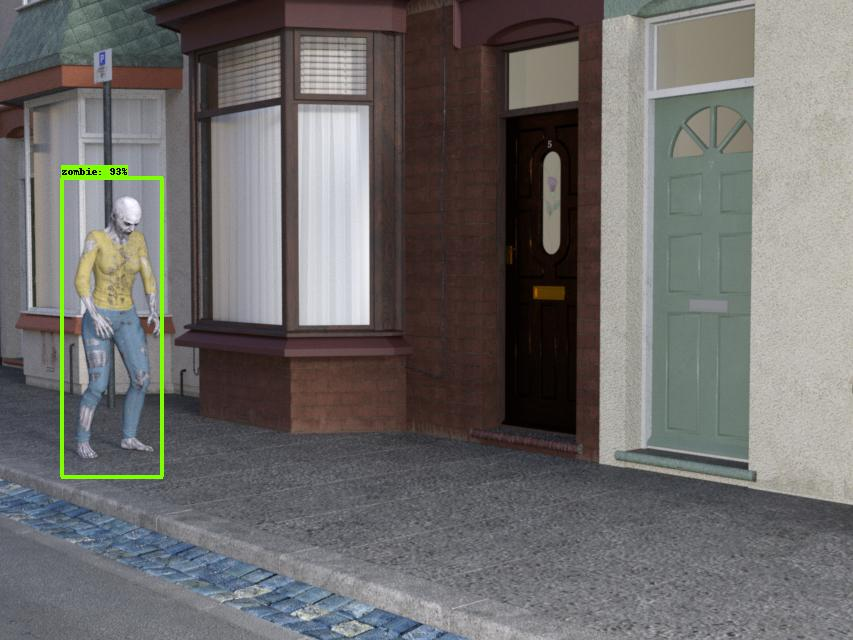


Frame 5


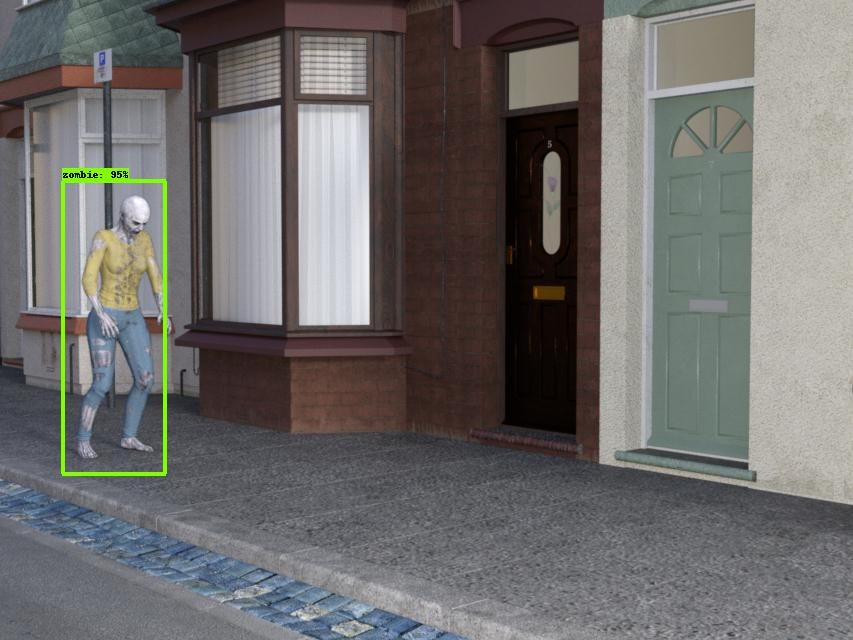


Frame 10


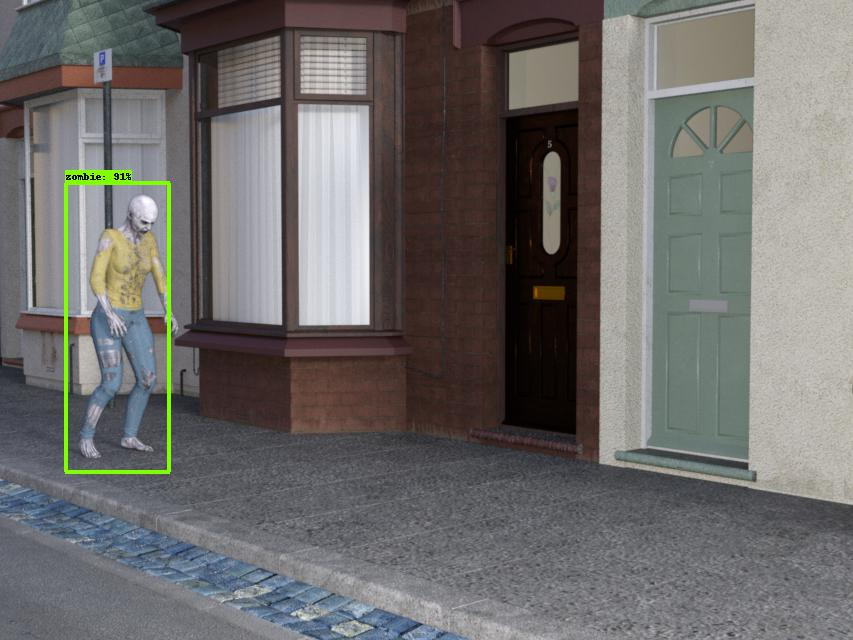

In [ ]:
print('Frame 0')
display(IPyImage('./results/gif_frame_000.jpg'))
print()
print('Frame 5')
display(IPyImage('./results/gif_frame_005.jpg'))
print()
print('Frame 10')
display(IPyImage('./results/gif_frame_010.jpg'))

## Crie um zip com as imagens do zombie-walk.
Você pode fazer o download se quiser criar suas próprias animações

In [ ]:
zipf = zipfile.ZipFile('./zombie.zip', 'w', zipfile.ZIP_DEFLATED)

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)

for filename in filenames:
    zipf.write(filename)

zipf.close()

## Criar animação de zumbis

In [ ]:
imageio.plugins.freeimage.download()

!rm -rf ./results/zombie-anim.gif

anim_file = './zombie-anim.gif'

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []

for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=10)

<ipython-input-60-c631f4650915>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Infelizmente, usar o `IPyImage` no notebook  para o grande `gif` gerado desconectará o tempo de execução. Para visualizar a animação, você pode usar o painel `Files` à esquerda e clicar duas vezes em `zombie-anim.gif`. Isso abrirá uma página de visualização à direita. Levará de 2 a 3 minutos para carregar e ver o zumbi andando.